In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from anomalyzer.config import loader
from anomalyzer.evaluate_performance import evaluate_performance
from anomalyzer.prepare_data import prepare_data

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

### Input Parameters

Specificy: 

1. Which _Day of Week_ to use ('Tuesday' or 'Wednesday')
2. _Model_ to make predictions ('isf' for Isolation Forest, 'svm' for One-Class SVM, 'cov' for Elliptic Envelope or 'lof' for Local Outlier Factor.
3. _Dimensions_ for PCA preprocessing (integer number, suggested value = 28)
4. Whether or not to use the model for _prediction_ or load existing predictions

In [2]:
day_of_week = 'Tuesday'
model = 'svm'
new_dimension = 28 #Choose the number of features for PCA
predict = True

### Load the data

In [3]:
data_file= loader(day_of_week=day_of_week,data_type='processed',subtype='Normalized')
df=pd.read_pickle(data_file)

## Preparing the Dataset for Anomaly Detection 

Here we need to separate our class variable, which in our case is "Label" from the rest of the dataset.

Anomaly detection algorithms output +1 for inlier and -1 for outliers. Therefore:

1. We need to map multiple classes to binary classes.
2. Since we are interesting in detecting anomalies, the negative class is 'BENIGN'.

In [4]:
X,y=prepare_data(data=df,class_column='Label',classes='binary',neg_class='BENIGN')

### Subset: Dimensionality Reduction w/ PCA

We first implement PCA on the dataset to reduce the number of features. The number of features is informed by the feature ranking provided by the xgboost models trained on the dataset.

In [5]:
pca_model = PCA(n_components=new_dimension, random_state=4162)
pca_model.fit(X)
x_red_pca = pca_model.transform(X)

### Predict or Load Anomalies

Returns 1 for inlier and -1 for outlier (aka anomalies)

In [6]:
if predict:
    filename='./models/'+str(model)+'_model_'+day_of_week+'_PCA_'+str(new_dimension)+'.pkl'

    with open(filename,'rb') as file:
        anomaly_model=pickle.load(file)
        
    anomalies = anomaly_model.predict(x_red_pca)
else:
    filename='./predictions/'+model+'_anomalies_'+day_of_week+'_PCA_'+str(new_dimension)+'.pkl'
    with open(filename,'rb') as file:
        anomalies=pickle.load(file)
        
anomalies = (anomalies+1)*0.5
anomalies = anomalies.astype(int)

### Performance measures

We choose to investigate the performance using 

1. Confusion Matrix (full picture of anomaly classification)
2. Accuracy
3. Precision of the anomaly class
4. Recall on the anomaly class
5. F-1 Measure on the anomaly class
6. AUC score

In [7]:
confusion_matrix(y,anomalies,labels=[0,1])

array([[208989, 222824],
       [ 13832,      0]], dtype=int64)

In [10]:
evaluate_performance(y,anomalies,dec_digits=3)

Accuracy: 0.469
Precision: 0.938
Recall: 0.484
f-1 score: 0.638
AUC score: 0.242


### Visualize detected anomalies

Load the t-SNE transformed data in 2-D for visualization if not already loaded.

In [11]:
try:
    _ = np.shape(x_vis)
except NameError:
    filename='./tsne_transforms/day_of_week_perplexity_30_data_445645.pkl'
    with open(filename,'rb') as file:
        x_vis=pickle.load(file)

Plot the detected anomalies in the t-SNE transformed 2-D representation of the data.

In [37]:
fraction = 0.1
sample_size = int(x_vis.shape[0]*fraction)

index = np.random.randint(0,x_vis.shape[0],sample_size)

x_red_vis = x_vis[index,:]

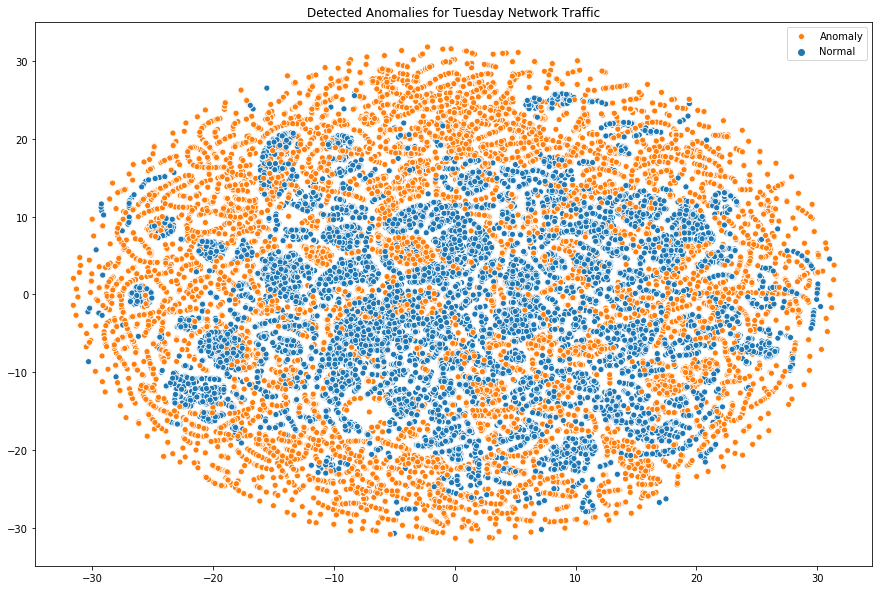

In [38]:
fig1=plt.figure(figsize=(15,10))
sns.scatterplot(x_red_vis[:,0],x_red_vis[:,1],hue=anomalies[index],hue_order=[1,0])
plt.title('Detected Anomalies for '+day_of_week+' Network Traffic')
plt.legend(['Anomaly','Normal'])
plt.show()

Plot the actual attacks on the network in the t-SNE transformed 2-D representation of the data.

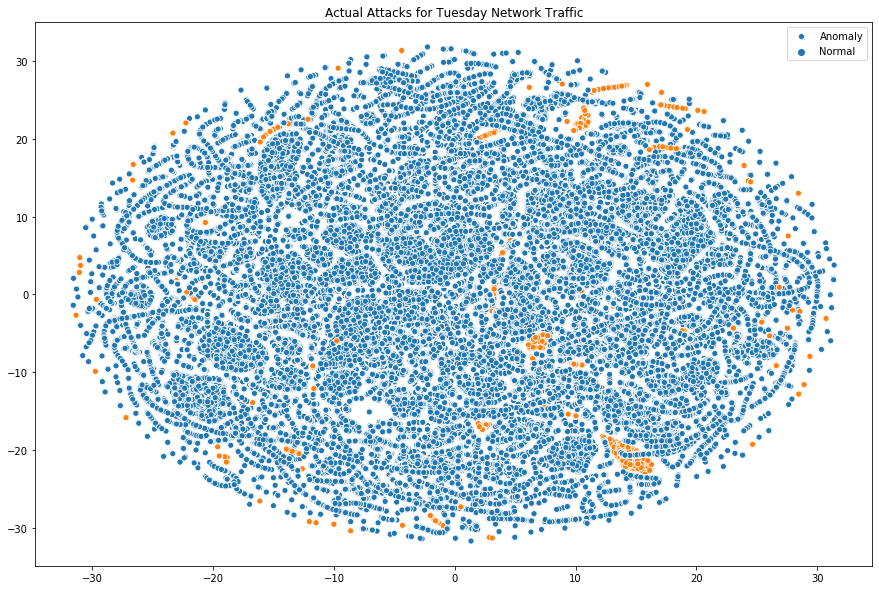

In [13]:
fig=plt.figure(figsize=(15,10))
sns.scatterplot(x_vis[:,0],x_vis[:,1],hue=y,hue_order=[0,1])
plt.title('Actual Attacks for '+day_of_week+' Network Traffic')
plt.legend(['Anomaly','Normal'])
plt.show()